In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.47.222.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.47.222.106:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


# Chargement et correction des données

Ce dataset est utilisé pour effectuer la prédiction de la température d'une pièce en fonction de plusieurs paramètres mesurés. La fréquence originale des données est d'une minute, puis a été modifiée à 15minutes avec un filtrage. L'ensemble correspond environ à une durée de 40 jours.  
Nous allons utiliser ici la température de la chambre comme cible et sélectionner 18 séries exogènes. 

**1. Chargement des données**

In [3]:
!rm *.txt
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/NEW-DATA-1.T15.txt"

rm: cannot remove '*.txt': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   181  100   181    0     0    721      0 --:--:-- --:--:-- --:--:--   721
100  386k  100  386k    0     0   864k      0 --:--:-- --:--:-- --:--:-- 13.1M


**2. Analyse et correction des données**

In [4]:
# Création de la série sous Pandas
df_etude = pd.read_csv("NEW-DATA-1.T15.txt",sep=" ")
df_etude

,Date,Time,Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,0,0,0,18.1150,48.3750,2.0
1,13/03/2012,12:00,18.4633,18.1207,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,0,0,0,18.4147,47.8080,2.0
2,13/03/2012,12:15,18.7673,18.4367,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,0,0,0,18.8533,47.4320,2.0
3,13/03/2012,12:30,19.0727,18.7513,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,0,0,0,19.2907,47.0240,2.0
4,13/03/2012,12:45,19.3721,19.0414,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,0,0,0,19.7400,45.4743,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,11/04/2012,05:30,21.1520,20.8187,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,0,0,0,16.6180,49.2960,3.0
2760,11/04/2012,05:45,21.0413,20.7053,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,0,0,0,16.4013,50.0373,3.0
2761,11/04/2012,06:00,20.9347,20.5827,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,0,0,0,16.2607,50.0587,3.0
2762,11/04/2012,06:15,20.8560,20.5200,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,0,0,0,16.2367,49.8400,3.0


Supprime les colonnes non utiles :
 - Date et heure
 - Exterior Entalpic 1, 2 et turbo  
   
Déplace la cible (4:Temperature_Habitacion_Sensor) en dernière colonne :

In [5]:
df_etude = df_etude.drop(['Date','Time','19:Exterior_Entalpic_1', '20:Exterior_Entalpic_2', '21:Exterior_Entalpic_turbo'],axis=1)
cible = df_etude.pop("4:Temperature_Habitacion_Sensor")
df_etude.insert(len(df_etude.columns),"Temperature_Habitacion_Sensor",cible)
df_etude

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week,Temperature_Habitacion_Sensor
0,18.1875,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,18.1150,48.3750,2.0,17.8275
1,18.4633,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,18.4147,47.8080,2.0,18.1207
2,18.7673,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,18.8533,47.4320,2.0,18.4367
3,19.0727,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,19.2907,47.0240,2.0,18.7513
4,19.3721,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,19.7400,45.4743,2.0,19.0414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.1520,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,16.6180,49.2960,3.0,20.8187
2760,21.0413,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,16.4013,50.0373,3.0,20.7053
2761,20.9347,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,16.2607,50.0587,3.0,20.5827
2762,20.8560,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,16.2367,49.8400,3.0,20.5200


Affiche les types :

In [6]:
df_etude.dtypes

Temperature_Comedor_Sensor        float64
5:Weather_Temperature             float64
6:CO2_Comedor_Sensor              float64
7:CO2_Habitacion_Sensor           float64
8:Humedad_Comedor_Sensor          float64
9:Humedad_Habitacion_Sensor       float64
10:Lighting_Comedor_Sensor        float64
11:Lighting_Habitacion_Sensor     float64
12:Precipitacion                  float64
13:Meteo_Exterior_Crepusculo      float64
14:Meteo_Exterior_Viento          float64
15:Meteo_Exterior_Sol_Oest        float64
16:Meteo_Exterior_Sol_Est         float64
17:Meteo_Exterior_Sol_Sud         float64
18:Meteo_Exterior_Piranometro     float64
22:Temperature_Exterior_Sensor    float64
23:Humedad_Exterior_Sensor        float64
24:Day_Of_Week                    float64
Temperature_Habitacion_Sensor     float64
dtype: object

Modifie les type en float32 :

In [7]:
df_etude = df_etude.astype(dtype='float32')
df_etude.dtypes

Temperature_Comedor_Sensor        float32
5:Weather_Temperature             float32
6:CO2_Comedor_Sensor              float32
7:CO2_Habitacion_Sensor           float32
8:Humedad_Comedor_Sensor          float32
9:Humedad_Habitacion_Sensor       float32
10:Lighting_Comedor_Sensor        float32
11:Lighting_Habitacion_Sensor     float32
12:Precipitacion                  float32
13:Meteo_Exterior_Crepusculo      float32
14:Meteo_Exterior_Viento          float32
15:Meteo_Exterior_Sol_Oest        float32
16:Meteo_Exterior_Sol_Est         float32
17:Meteo_Exterior_Sol_Sud         float32
18:Meteo_Exterior_Piranometro     float32
22:Temperature_Exterior_Sensor    float32
23:Humedad_Exterior_Sensor        float32
24:Day_Of_Week                    float32
Temperature_Habitacion_Sensor     float32
dtype: object

**5. Affiche les données**

In [8]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['Temperature_Habitacion_Sensor'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Séparation des données de test et d'entrainement

In [9]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 2211
Taille de la validation : 553


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [10]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [11]:
print(serie_entrainement_X_norm.shape)
print(serie_test_X_norm.shape)

(2211, 19)
(553, 19)


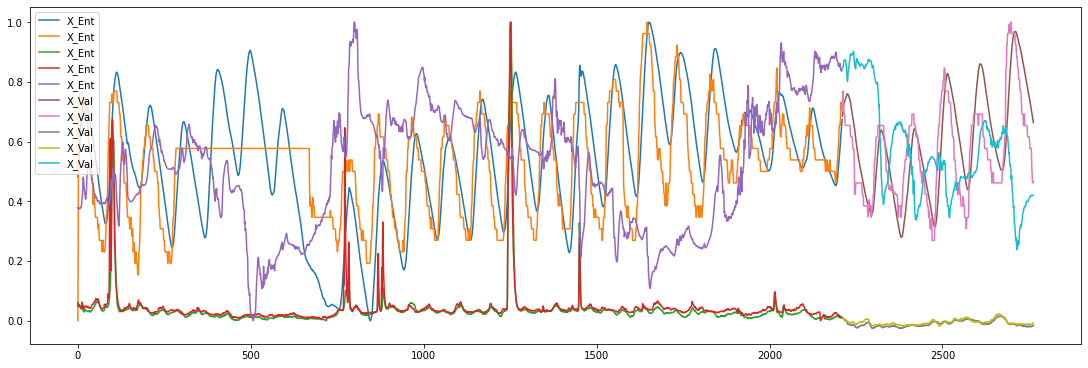

In [12]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création des datasets

In [13]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-longueur_sortie:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [14]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 20
longueur_sortie = 5
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [15]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1

17
(128, 20, 18)
(128, 20, 1)
(128, 5, 1)


In [16]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1

4
(128, 20, 18)
(128, 20, 1)
(128, 5, 1)


**3. Préparation des X/Y**

In [17]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(2176, 20, 18)
(2176, 20, 1)
(2176, 5, 1)


In [18]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(512, 20, 18)
(512, 20, 1)
(512, 5, 1)


# Affichage des séries

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(np.linspace(0,longueur_sequence,longueur_sequence),x_train[0][0,:,0:3],label="X_train (X)")
ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence-1),x_train[1][0,:,:],label="X_train (Y)")

ax.plot(np.linspace(longueur_sequence,longueur_sequence+1,1),y_train[0,:,:],label="Y_train",marker="*")

ax.legend()
plt.show()

# Création du modèle STAM

Le modèle STAM implanté est le suivant :

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/VueGenerale.png?raw=true">

**1. Création de la couche de création des motifs spatiaux**

In [19]:
class CreationMotifsSpatiaux(tf.keras.layers.Layer):
  def __init__(self, dim_motifs):
    self.dim_motifs = dim_motifs
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    couches_denses = []
    input_couches_denses = []

    # Création des N entrées des couches denses
    for i in range(input_shape[2]):
      input_couches_denses.append(tf.keras.Input(shape=(input_shape[1])))                   # input = N*(batch_size,Tin)

    # Création des N couches denses
    for i in range(input_shape[2]):
      couche_dense = tf.keras.layers.Dense(units=self.dim_motifs)(input_couches_denses[i])    # couche_dense : (batch_size,dim_motif)
      couches_denses.append(couche_dense)

    # Création de la sortie des N couches denses
    out = tf.convert_to_tensor(couches_denses)                  # (N,batch_size,dim_motif)
    out = tf.transpose(out,perm=[1,0,2])                        # (batch_size,N,dim_motif)

    # Création du modèle global
    self.Dense_Motifs = tf.keras.Model(inputs=input_couches_denses,outputs=out)
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:            Séries exogènes & cibles  : (batch_size,Tin,N)
  # Sorties :
  #     space_motifs:     Motifs spatiaux           : (batch_size,N,dim_motif)
  def call(self, input):
    input_list = tf.unstack(input,axis=2)           # N*(batch_size,Tin)
    space_motifs = self.Dense_Motifs(input_list)    # (batch_size,N,dim_motifs)
    return space_motifs

**2. Création de la couche de création des motifs temporels**

In [20]:
class CreationMotifsTemporels(tf.keras.layers.Layer):
  def __init__(self, dim_motifs):
    self.dim_motifs = dim_motifs
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_lstm1 = tf.keras.layers.LSTM(units=self.dim_motifs,return_sequences=True)
    self.couche_lstm2 = tf.keras.layers.LSTM(units=self.dim_motifs,return_sequences=True)
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:            Séries exogènes & cible  : (batch_size,Tin,N)
  # Sorties :
  #     temp_motifs:      Motifs temporels          : (batch_size,Tin,dim_motif)
  def call(self, input):
    out_lstm = self.couche_lstm1(input)            # (batch_size,Tin,dim_motif)
    out_lstm = self.couche_lstm2(out_lstm)         # (batch_size,Tin,dim_motif)
    return out_lstm

**3. Création de la couche d'attention de l'encodeur spatial**

On commence par créer la couche de calcul du score de l'encodeur spatial.  
Cette fonction est appellée par la couche d'attention spatiale à l'aide de la méthode TimeDistribued de Keras.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/EncodeurSpatialSTAM_CalculScore2.png?raw=true'>

In [21]:
class CalculScores_EncodeurSpatial(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                  # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.CoucheDenseScoresEncSpatial = tf.keras.layers.Dense(units=1,activation="relu")
    super().build(input_shape)        # Appel de la méthode build()

  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)


  #     hidd_state:     hidden_state        : (batch_size,#LSTMG)
  def SetStates(self,hidd_state):
    self.hidd_state = hidd_state

   # Entrées :
  #     motifs :      Motifs spatiaux               : (batch_size,#space)
  # Sorties :
  #     score :       score                         : (batch_size,1)
  def call(self,motifs):
    motifs = tf.concat([motifs,self.hidd_state],axis=1)         # (batch_size,#space+#LSTMG)
    score = self.CoucheDenseScoresEncSpatial(motifs)      # (batch_size,1)
    return score

Puis maintenant la couche d'attention :

In [22]:
class CalculAttention_EncodeurSpatial(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_CalculScores_EncodeurSpatial = CalculScores_EncodeurSpatial()
    super().build(input_shape)        # Appel de la méthode build()


  # Entrées :
  #     input :       Motifs spatiaux               : (batch_size,N,#space)
  #     hid_state :   Hidden state décodeur spatial : (batch_size,#LSTMG)
  # Sorties :
  #     vect_contexte   Vecteur Contexte    : (batch_size,#space)
  def call(self, input,hid_state):
    # Calcul des scores
    self.couche_CalculScores_EncodeurSpatial.SetStates(hid_state)
    b = tf.keras.layers.TimeDistributed(
        self.couche_CalculScores_EncodeurSpatial)(input)                      # (batch_size,N,#space) : Timestep=N
                                                                              # (batch_size,#space) envoyé N fois en //
                                                                              # (batch_size,N,1) retourné
    # Normalisation des scores
    b = tf.keras.activations.softmax(b,axis=1)                                # (batch_size,N,1)

    # Calcul du vecteur contexte
    g = tf.multiply(input,b)        # (batch_size,N,#space)_x_(batch_size,N,1) = (batch_size,N,#space)
    g = K.sum(g,axis=1)             # (batch_size,#space)
    return g


**4. Création de la couche d'attention de l'encodeur temporel**

On commence par créer la couche de calcul du score de l'encodeur spatial.  
Cette fonction est appellée par la couche d'attention spatiale à l'aide de la méthode TimeDistribued de Keras.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/EncodeurTemporelSTAM_CalculScore2.png?raw=true'>

In [23]:
class CalculScores_EncodeurTemporel(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                  # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.CoucheDenseScoresEncTemporel = tf.keras.layers.Dense(units=1,activation="relu")
    super().build(input_shape)        # Appel de la méthode build()

  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)

  #     hidd_state:     hidden_state        : (batch_size,#LSTMG)
  def SetStates(self,hidd_state):
    self.hidd_state = hidd_state

   # Entrées :
  #      motifs :      Motifs temporels               : (batch_size,#tempo)
  # Sorties :
  #     score :       score                         : (batch_size,1)
  def call(self,motifs):
    motifs = tf.concat([motifs,self.hidd_state],axis=1)         # (batch_size,#tempo+#LSTMS)
    score = self.CoucheDenseScoresEncTemporel(motifs)           # (batch_size,1)
    return score

Puis maintenant la couche d'attention :

In [25]:
class CalculAttention_EncodeurTemporel(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_CalculScores_EncodeurTemporel = CalculScores_EncodeurTemporel()
    super().build(input_shape)        # Appel de la méthode build()


  # Entrées :
  #     motifs :      Motifs temporels               : (batch_size,T,#tempo)
  #     hid_state :   Hidden state décodeur tempo    : (batch_size,#LSTMS)
  # Sorties :
  #     vect_contexte   Vecteur Contexte    : (batch_size,#tempo)
  def call(self, input,hid_state):
    # Calcul des scores
    self.couche_CalculScores_EncodeurTemporel.SetStates(hid_state)
    b = tf.keras.layers.TimeDistributed(
        self.couche_CalculScores_EncodeurTemporel)(input)                     # (batch_size,T,#tempo) : Timestep=T
                                                                              # (batch_size,#tempo) envoyé T fois en //
                                                                              # (batch_size,T,1) retourné
    # Normalisation des scores
    b = tf.keras.activations.softmax(b,axis=1)                                # (batch_size,T,1)

    # Calcul du vecteur contexte
    g = tf.multiply(input,b)        # (batch_size,T,#tempo)_x_(batch_size,T,1) = (batch_size,T,#tempo)
    g = K.sum(g,axis=1)             # (batch_size,#tempo)
    return g


**5. Création de la couche du décodeur spatial**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/CoucheDecodeurSpatialSTAM.png?raw=true' width=800>

In [37]:
class DecodeurSpatial(tf.keras.layers.Layer):
  def __init__(self, dim_LSTMG,dim_G,regul,drop):
    self.drop = drop
    self.regul = regul
    self.dim_LSTMG = dim_LSTMG          # Dimension des vecteurs cachés
    self.dim_G = dim_G                  # dimension réduite du vecteur contexte
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.CoucheReductionSpatiale = tf.keras.layers.Dense(units=self.dim_G,activation="relu")
    self.CoucheLSTMG = tf.keras.layers.LSTM(units=self.dim_LSTMG,return_state=True,kernel_regularizer=tf.keras.regularizers.l2(self.regul),dropout=self.drop,recurrent_dropout=self.drop,name="LSTM_DecodeurSpatial")
    super().build(input_shape)        # Appel de la méthode build()


  # Entrées :
  #     vc_spatial :      Vecteur Contexte spatial                : (batch_size,#space)
  #     hid_state_1 :     Hidden state décodeur spatial (t-1)     : (batch_size,#LSTMG)
  #     cell_state_1 :    Cell state décodeur spatial (t-1)       : (batch_size,#LSTMG)
  #     y_pred_1 :        Prédiction (t-1)                        : (batch_size,1,1)
  # Sorties :
  #     hid_state :       Hidden state décodeur spatial (t)       : (batch_size,#LSTMG)
  #     cell_state :      Cell state décodeur spatial (t)         : (batch_size,#LSTMG)

  def call(self, vc_spatial,hid_state_1,cell_state_1,y_pred_1):
    # Réduction du vecteur contexte
    rg = self.CoucheReductionSpatiale(vc_spatial)                         # (batch_size,dim_G)

    # Concaténation du vecteur réduit avec la prédictionà (t-1)
    rg = tf.concat([rg,tf.squeeze(y_pred_1,-1)],axis=1)           # (batch_size,dim_G+1)
    rg = tf.expand_dims(rg,-1)                                    # (batch_size,dim_G+1,1)

    # Applique le résultat au LSTMG
    out_dec, hid_state, cell_state = self.CoucheLSTMG(rg,initial_state=[hid_state_1,cell_state_1])         # hid_state / cell_state : (batch_size,#LSTMG)
    return hid_state,cell_state


**6. Création de la couche du décodeur temporel**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/CoucheDecodeurTemporelSTAM.png?raw=true' width=800>

In [28]:
class DecodeurTemporel(tf.keras.layers.Layer):
  def __init__(self, dim_LSTMS,dim_S,regul,drop):
    self.drop = drop
    self.regul = regul
    self.dim_LSTMS = dim_LSTMS          # Dimension des vecteurs cachés
    self.dim_S = dim_S                  # dimension réduite du vecteur contexte
    super().__init__()                  # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.CoucheReductionTemporelle = tf.keras.layers.Dense(units=self.dim_S,activation="relu")
    self.CoucheLSTMS = tf.keras.layers.LSTM(units=self.dim_LSTMS,return_state=True,kernel_regularizer=tf.keras.regularizers.l2(self.regul),dropout=self.drop,recurrent_dropout=self.drop,name="LSTM_DecodeurTemporel")
    super().build(input_shape)        # Appel de la méthode build()


  # Entrées :
  #     vc_tempo :        Vecteur Contexte temporel               : (batch_size,#tempo)
  #     hid_state_1 :     Hidden state décodeur tempo (t-1)       : (batch_size,#LSTMS)
  #     cell_state_1 :    Cell state décodeur tempo (t-1)         : (batch_size,#LSTMS)
  #     y_pred_1 :        Prédiction (t-1)                        : (batch_size,1,1)
  # Sorties :
  #     hid_state :       Hidden state décodeur tempo (t)         : (batch_size,#LSTMS)
  #     cell_state :      Cell state décodeur tempo (t)           : (batch_size,#LSTMS)

  def call(self, vc_tempo,hid_state_1,cell_state_1,y_pred_1):
    # Réduction du vecteur contexte
    rs = self.CoucheReductionTemporelle(vc_tempo)                 # (batch_size,dim_S)

    # Concaténation du vecteur réduit avec la prédictionà (t-1)
    rs = tf.concat([rs,tf.squeeze(y_pred_1,-1)],axis=1)           # (batch_size,dim_S+1)
    rs = tf.expand_dims(rs,-1)                                    # (batch_size,dimg_S+1,1)

    # Applique le résultat au LSTMG
    out_dec, hid_state, cell_state = self.CoucheLSTMS(rs,initial_state=[hid_state_1,cell_state_1])         # hid_state / cell_state : (batch_size,#LSTMS)
    return hid_state,cell_state


**4. Création de la couche réseau**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/ReseauSTAM.png?raw=true'>

In [76]:
class Net_STAM(tf.keras.layers.Layer):
  def __init__(self,creationmotifsspatiaux, creationmotifstemporels, encodeurspatial,encodeurtemporel, decodeurspatial,decodeurtemporel,longueur_sequence, longueur_sortie, regul, drop,dim_LSTMG,dim_LSTMS):
    self.creationmotifsspatiaux = creationmotifsspatiaux
    self.creationmotifstemporels = creationmotifstemporels
    self.encodeurspatial = encodeurspatial
    self.encodeurtemporel = encodeurtemporel
    self.decodeurspatial = decodeurspatial
    self.decodeurtemporel = decodeurtemporel
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.drop = drop
    self.dim_LSTMG = dim_LSTMG
    self.dim_LSTMS = dim_LSTMS
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.CoucheConcatenation = tf.keras.layers.Dense(units=self.dim_LSTMG+self.dim_LSTMS,activation="tanh")
    self.CoucheGenerateur = tf.keras.layers.Dense(units=1)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Series exogènes     : (batch_size,Tin,#dim)
  #     cible:          Cible               : (batch_size,Tin,1)
  # Sorties :
  #     sortie:         Prédiction Y        : (batch_size,longueur_sortie,1)
  def call(self,input,cible):
    # Création des motifs spatiaux et temporels
    motifs_spatiaux = self.creationmotifsspatiaux(tf.concat([input,cible],axis=2))      # (batch_size,N,#space) N=#dim+1
    motifs_temporels = self.creationmotifstemporels(tf.concat([input,cible],axis=2))    # (batch_size,N,#tempo)

    # Initialise les hidden_states et les cells_states
    hid_state_spatial_1 = tf.matmul(input[:,0:1,0:1],tf.zeros(shape=(1,self.dim_LSTMG)))    # (batch_size,1,1)x(1,#LSTMG) = (batch_size,1,#LSTMG)
    hid_state_spatial_1 = tf.transpose(hid_state_spatial_1,perm=[0,2,1])                    # (batch_size,#LSTMG,1)
    hid_state_spatial_1 = tf.squeeze(hid_state_spatial_1,-1)                                # (batch_size,1)
    cell_state_spatial_1 = hid_state_spatial_1

    hid_state_temporel_1 = tf.matmul(input[:,0:1,0:1],tf.zeros(shape=(1,self.dim_LSTMS)))    # (batch_size,1,1)x(1,#LSTMS) = (batch_size,1,#LSTMS)
    hid_state_temporel_1 = tf.transpose(hid_state_temporel_1,perm=[0,2,1])                   # (batch_size,#LSTMS,1)
    hid_state_temporel_1 = tf.squeeze(hid_state_temporel_1,-1)                               # (batch_size,1)
    cell_state_temporel_1 = hid_state_temporel_1

    # Initialise la prédiction à t=0
    y_pred_1 = tf.matmul(cible[:,0:1,:],tf.zeros(shape=(1,1)))    # (batch_size,1,1)x(1,1) = (batch_size,1,1)

    sorties = []

    for t in range(self.longueur_sortie):
      # Calcul des vecteurs contextes spatiaux et temporels
      g = self.encodeurspatial(motifs_spatiaux,hid_state_spatial_1)                               # (batch_size,#space)
      s = self.encodeurtemporel(motifs_temporels,hid_state_temporel_1)                            # (batch_size,#tempo)

      # Décodeur spatial & temporel
      hid_state_dec_spatial,cell_state_dec_spatial = self.decodeurspatial(                        # (batch_size,#LSTMG)
          g,hid_state_spatial_1,cell_state_spatial_1,y_pred_1)
      hid_state_dec_temporel,cell_state_dec_temporel = self.decodeurtemporel(                     # (batch_size,#LSTMS)
          s,hid_state_temporel_1,cell_state_temporel_1,y_pred_1)
      
      # Concaténation des hidden states et des vecteurs contextes
      out_dec = tf.concat([hid_state_dec_spatial,hid_state_dec_temporel,g,s],axis=1)              # (batch_size,#LSTMG+LSTMS+#space+#tempo)

      y_pred_1 = self.CoucheConcatenation(out_dec)                                                # (batch_size,#LSTMG+#LSTMS)
      y_pred_1 = self.CoucheGenerateur(y_pred_1)                                                 # (batch_size,1)
      y_pred_1 = tf.expand_dims(y_pred_1,-1)                                                      # (batch_size,1,1)

      sorties.append(y_pred_1)
      hid_state_spatial_1 = hid_state_dec_spatial
      cell_state_spatial_1 = cell_state_dec_spatial
      hid_state_temporel_1 = hid_state_dec_temporel
      cell_state_temporel_1 = cell_state_dec_temporel

    sorties = tf.convert_to_tensor(sorties)         # (longueur_sortie,batch_size,1,1)
    sorties = tf.squeeze(sorties,-1)                # (longueur_sortie,batch_size,1)
    sorties = tf.transpose(sorties,perm=[1,0,2])    # (batch_size,longueur_sortie,1)

    return sorties

**4. Création du modèle**

In [80]:
dim_motifs_spatiaux = 128
dim_motifs_temporels = 128

dim_LSTMG = 128
dim_G = 128
dim_LSTMS = 128
dim_S = 128
drop=0.0
l2reg=0.0

def get_model():
  entrees_exo = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]))
  entrees_cible = tf.keras.layers.Input(shape=(longueur_sequence,1))

  creationmotifsspatiaux = CreationMotifsSpatiaux(dim_motifs=dim_motifs_spatiaux)
  creationmotifstemporels = CreationMotifsTemporels(dim_motifs=dim_motifs_temporels)
  encodeurspatial = CalculAttention_EncodeurSpatial()
  encodeurtemporel = CalculAttention_EncodeurTemporel()
  decodeurspatial = DecodeurSpatial(dim_LSTMG=dim_LSTMG,dim_G=dim_G,regul=l2reg,drop=drop)
  decodeurtemporel = DecodeurTemporel(dim_LSTMS=dim_LSTMS,dim_S=dim_S,regul=l2reg,drop=drop)


  sortie = Net_STAM(creationmotifsspatiaux,creationmotifstemporels,encodeurspatial,encodeurtemporel,decodeurspatial,decodeurtemporel,longueur_sequence,longueur_sortie,l2reg,drop,dim_LSTMG,dim_LSTMS)(entrees_exo,entrees_cible)

  model = tf.keras.Model([entrees_exo,entrees_cible],sortie)
  return model

# Entrainement avec TPU

In [86]:
from google.colab import files

max_periodes = 500

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur)

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=60)],batch_size=batch_size)

files.download('poids_train.hdf5')

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/500
17/17 [==============================] - 46s 601ms/step - loss: 0.0530 - val_loss: 0.0052

Epoch 00001: loss improved from inf to 0.05296, saving model to poids_train.hdf5
Epoch 2/500
17/17 [==============================] - 1s 78ms/step - loss: 0.0068 - val_loss: 0.0058

Epoch 00002: loss improved from 0.05296 to 0.00677, saving model to poids_train.hdf5
Epoch 3/500
17/17 [==============================] - 1s 78ms/step - loss: 0.0032 - val_loss: 0.0015

Epoch 00003: loss improved from 0.00677 to 0.00316, saving model to poids_train.hdf5
Epoch 4/500
17/17 [==============================] - 1s 78ms/step - loss: 0.0019 - val_loss: 0.0014

Epoch 00004: loss improved from 0.00316 to 0.00191, saving model to poids_train.hdf5
Epoch 5/500
17/17 [==============================] - 1s 78ms/step - loss: 0.0015 - val_loss: 0.0011

Epoch 00005: loss improved from 0.00191 to 0.00153, saving model to poids_train.hdf5
Epoch 6/500
17/17 [==============================] - 1s 78ms/step - loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
model.load_weights("poids_train.hdf5")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

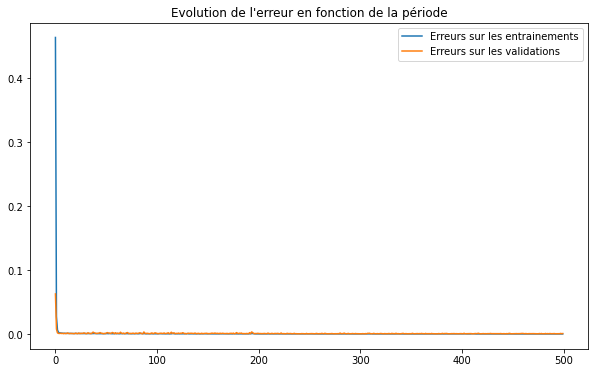

In [83]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

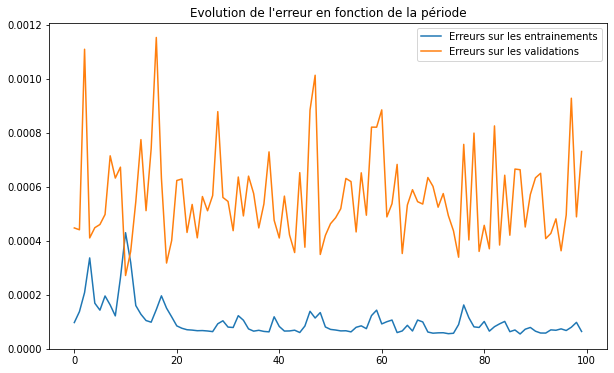

In [84]:
start = 400

erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[start:])),erreur_entrainement[start:], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[start:])),erreur_validation[start:], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [85]:
model.evaluate(x=[x_train[0],x_train[1]],y=y_train)
model.evaluate(x=[x_val[0],x_val[1]],y=y_val)

16/16 [==============================] - 1s 15ms/step - loss: 6.6248e-04


0.0006624820525757968

# Chargement du modèle pré-entrainé

**DA-RNN2_10_SML2010**  

  - Vecteur LSTM : 128  
  - Longueur entrée : 10  
  - Longueur sortie : 1
  - Drop : 0.0
  - L2 : 0.00  
  - Batch Size : 128  
  - Périodes : 500   
	=> mse :  


In [ ]:
model = get_model()

In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Models/Multi_DA-RNN2_SML2010_L10.hdf5"

In [ ]:
model.load_weights("Multi_DA-RNN2_SML2010_L10.hdf5")

# Prédictions Multistep

In [56]:
pred_ent = model.predict([x_train[0],x_train[1]],verbose=1)
pred_val = model.predict([x_val[0],x_val[1]],verbose=1)

16/16 [==============================] - 1s 9ms/step


In [57]:
import plotly.graph_objects as go

decalage = longueur_sortie

fig = go.Figure()

# Affiche les courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=tf.squeeze(serie_entrainement_X_norm[:,-1:],-1),line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=tf.squeeze(serie_test_X_norm[:,-1:],-1),line=dict(color='red', width=1)))

#Calcul les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_ent)/longueur_sortie)
#max = 10
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[longueur_sequence+i*longueur_sortie:longueur_sequence+(i+1)*longueur_sortie])
  step_val.append(pred_ent[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[longueur_sequence+i*longueur_sortie])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pred_index,y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))

#Calcul les prédictions sur les validations
pred = []
pred_index = []
step_time = []
step_val = []
max = int(len(pred_val)/longueur_sortie)
#max = 10
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[temps_separation+i*decalage+longueur_sequence:temps_separation+i*decalage+longueur_sequence+longueur_sortie])
  step_val.append(pred_val[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[temps_separation+i*decalage+longueur_sequence])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))
pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pred_index,y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))

# Affiche les prédictions
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en multi step**

In [58]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = longueur_sortie

#Calcul les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_ent)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i*longueur_sortie,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [59]:
import plotly.graph_objects as go

fig = go.Figure()

#Calcul les prédictions sur les validations
pred = []
max = int(len(pred_val)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i*longueur_sortie,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [60]:
print(mse_ent)
print(mse_test)

tf.Tensor(2.9920935e-05, shape=(), dtype=float32)
tf.Tensor(0.00027127741, shape=(), dtype=float32)
